In [ ]:
data_dir = "/content/drive/MyDrive/mnist_dataset.csv"

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


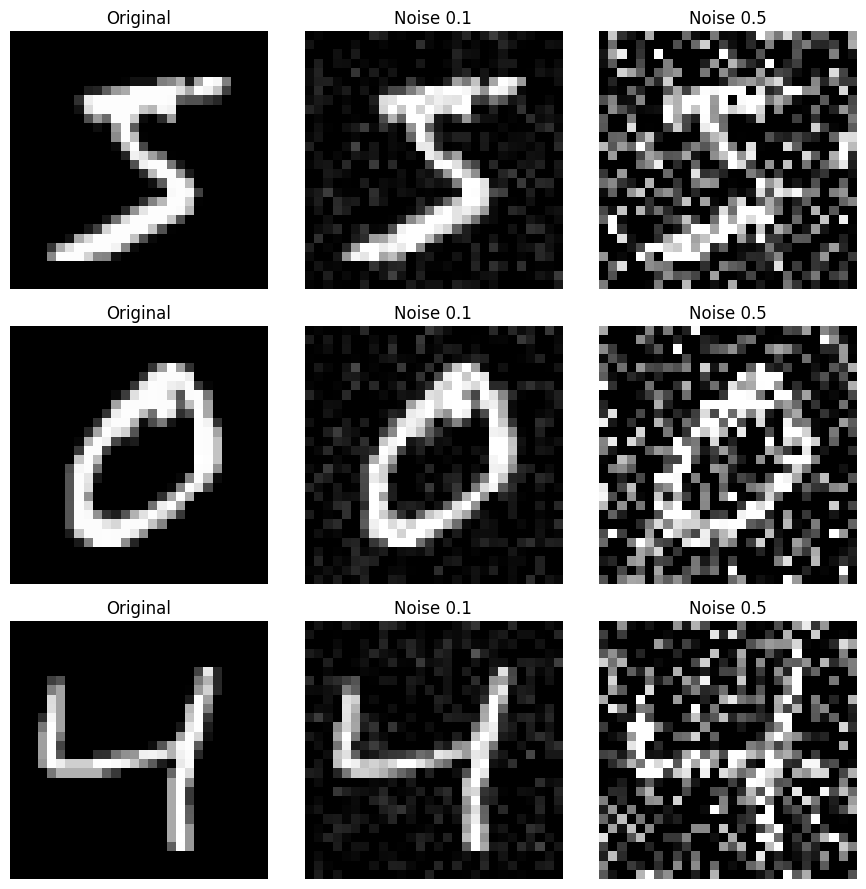

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load and preprocess MNIST
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Generate noisy versions
noise_factor_low = 0.1
noise_factor_high = 0.5

x_train_noisy_low = x_train + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_train_noisy_high = x_train + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy_low = x_test + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_test_noisy_high = x_test + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip pixel values to [0, 1]
x_train_noisy_low = np.clip(x_train_noisy_low, 0., 1.)
x_train_noisy_high = np.clip(x_train_noisy_high, 0., 1.)
x_test_noisy_low = np.clip(x_test_noisy_low, 0., 1.)
x_test_noisy_high = np.clip(x_test_noisy_high, 0., 1.)

# Visualize in a 3 x 3 grid
n = 3  # number of images to show
plt.figure(figsize=(9, 9))

for i in range(n):
    # Original image
    ax = plt.subplot(n, 3, i * 3 + 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Low noise image
    ax = plt.subplot(n, 3, i * 3 + 2)
    plt.imshow(x_train_noisy_low[i].reshape(28, 28), cmap='gray')
    plt.title("Noise 0.1")
    plt.axis('off')

    # High noise image
    ax = plt.subplot(n, 3, i * 3 + 3)
    plt.imshow(x_train_noisy_high[i].reshape(28, 28), cmap='gray')
    plt.title("Noise 0.5")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Build the convolutional Dsecoding Autoencoder Model


Encoder

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D

def build_encoder(input_shape=(28, 28, 1)):
    input_img = Input(shape=input_shape, name="input")

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name="encoded")(x)

    return input_img, encoded


Decoder


In [ ]:
def build_decoder(encoded_input):

  x = Conv2D(64, (3, 3), activation=’relu’, padding=’same’)(encoded_input)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), activation=’relu’, padding=’same’)(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(1, (3, 3), activation=’sigmoid’, padding=’same’, name="decoded")(x)
return decoded

Complete Autoencoder

In [ ]:
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D

def build_decoder(encoded_input):
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded_input)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="decoded")(x)

    return decoded



Compile the Model

In [ ]:
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoded (MaxPooling2D)               │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoded (Conv2D)                     │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

Train the Autoencoder


In [ ]:
# Build the autoencoder from previous steps
autoencoder = build_autoencoder()
# Train with noisy input and clean target
history = autoencoder.fit(
x_train_noisy_high, x_train,
epochs=10,
batch_size=128,
shuffle=True,
validation_data=(x_test_noisy_high, x_test)
)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 192s 401ms/step - loss: 0.2271 - val_loss: 0.1134
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 198s 392ms/step - loss: 0.1119 - val_loss: 0.1045
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 201s 390ms/step - loss: 0.1052 - val_loss: 0.1015
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 204s 395ms/step - loss: 0.1024 - val_loss: 0.0998
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 199s 390ms/step - loss: 0.1005 - val_loss: 0.0987
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 203s 391ms/step - loss: 0.0994 - val_loss: 0.0977
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 204s 396ms/step - loss: 0.0983 - val_loss: 0.0973
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 199s 390ms/step - loss: 0.0978 - val_loss: 0.0963
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 201s 388ms/step - loss: 0.0970 - val_loss: 0.0958
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 186s 397ms/step - loss: 0.0964 - val_loss: 0.0952


Evaluate the Autoencoder


In [ ]:
import matplotlib.pyplot as plt

# Predict the denoised images from noisy test images
denoised_images = autoencoder.predict(x_test_noisy)

# Function to display images
def plot_images(noisy_images, denoised_images, clean_images, n=10):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Plot noisy images
        plt.subplot(3, n, i + 1)
        plt.imshow(noisy_images[i].reshape(28, 28), cmap='gray')
        plt.title("Noisy Image")
        plt.axis('off')

        # Plot denoised images
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
        plt.title("Denoised Image")
        plt.axis('off')

        # Plot clean images
        plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(clean_images[i].reshape(28, 28), cmap='gray')
        plt.title("Clean Image")
        plt.axis('off')

    plt.show()

# Display the first 10 images
plot_images(x_test_noisy, denoised_images, x_test, n=10)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


Load and Preprocess Dataset


In [1]:
!unzip /content/drive/MyDrive/devnagari_digit.zip

unzip:  cannot find or open /content/drive/MyDrive/devnagari_digit.zip, /content/drive/MyDrive/devnagari_digit.zip.zip or /content/drive/MyDrive/devnagari_digit.zip.ZIP.


In [ ]:
# Load images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename)).convert('L')
        img = img.resize((32, 32))
        images.append(np.array(img))
    return np.array(images)

dataset_path = '/content/drive/MyDrive/devnagari_digit.zip'
images = load_images_from_folder(dataset_path)

# Normalize & Reshape
images = images.astype('float32') / 255.0
images = np.expand_dims(images, axis=-1)

x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)
